In [1]:
import numpy as np
import scipy
from scipy import linalg 
from scipy import integrate
from scipy import stats
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import special
import time

Some functions used to compute the implied volatility, here S_0=exp(X_0), x0 is the initial guess:

In [2]:
def BS_formula_call(S_0,K,r,sigma,T):
    d_1=(np.log(S_0/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d_2=d_1-sigma*np.sqrt(T)
    return S_0*norm.cdf(d_1)-K*np.exp(-r*T)*norm.cdf(d_2)

def derivative (price,r,K,T,sigma,S_0):
    d_1=(np.log(S_0/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    return S_0*np.sqrt(T)*np.exp(-d_1**2/2)/np.sqrt(2*np.pi)

#here n is the number of algorhitm iterations
def Newton (S_0,x0,price,r,K,T,n):
    x=x0
    i=0
    while i<n:
        x=x0
        der=derivative(price,r,K,T,x,S_0)
        fun=BS_formula_call(S_0,K,r,x,T)-price
        x=x-fun/der
        i=i+1
    return x

For the code it will be a great idea to use the stirling approximation, because it's way faster than the computation of the factorial itself.

In [3]:
#stirling approximation will make computation of the squared factorial not only possible for bigger n, but also way faster
def rooted_stirling(n):
    return np.float64((2*math.pi*n)**(1/4)*(n/math.e)**(n/2))

As we can see, even for small n the approximation is very good:

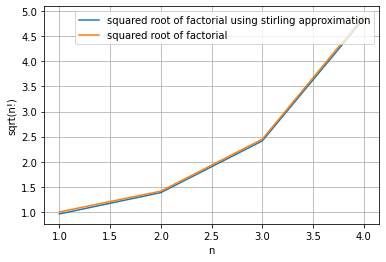

In [4]:
x=np.arange(1,5)
rooted_factorial_stirling=rooted_stirling(x)

start_2=time.time()
x=x.astype(int)
rooted_factorial=np.sqrt(scipy.special.factorial(x))

plt.plot(x,rooted_factorial_stirling, label="squared root of factorial using stirling approximation")
plt.plot(x,rooted_factorial, label="squared root of factorial")
plt.xlabel("n")
plt.ylabel("sqrt(n!)")
plt.legend(loc="upper right")
plt.grid()
plt.show()

The function below computes hermite moments l_n according to he Appendix A. First of all using a loop we are makeing list ordered_pairs that will be a reference point for the enumeration of pairs (m,n). To save some of the computation time we are computing the values of V_0^m only one time for each m and then put them in a vector, same for the values of Hermite polynomials. Nentherless, clearly the bootle neck of this algorhitm (and the implementation as a whole) is the computing the exponent of matrix G. In order to deal with this problem one may use the algorithm from http://eprints.ma.man.ac.uk/1591/1/covered/MIMS_ep2010_30.pdf.

In [5]:
#the first parameter is the order of truncation, the second one if from which iteration the stirling appriximation will be used
def hermite_moments (N, stirling_approx_n, sigma, rho, sigma_w, mu_w, kappa, theta, r, delta,  v_min, v_max, T, V_0, X_0):
    ordered_pairs=[]
    for i in range(N+1):
        for j in range(N+1):
            if i+j<=N:
                ordered_pairs.append([i,j])
    M=len(ordered_pairs)
    G=np.zeros((M,M))
    for m in range(M):
        for n in range(M):
            if m+n>N:
                break
            index_column=ordered_pairs.index([m,n])
            if m>=2:
                index=ordered_pairs.index([m-2,n])
                G[index,index_column] = - (sigma**2*m*(m-1)*v_max*v_min) / (2*(math.sqrt(v_max) - math.sqrt(v_min))**2)
            if ((n>=1) and (m>=1)):
                index=ordered_pairs.index([m-1,n-1])
                G[index,index_column] = - (sigma*rho*m*math.sqrt(n)*v_max*v_min) / (sigma_w*(math.sqrt(v_max) - math.sqrt(v_min))**2)
            if m>=1:
                index=ordered_pairs.index([m-1,n])
                G[index,index_column] = kappa*theta*m + (sigma**2*m*(m-1)*(v_max + v_min)) / (2*(math.sqrt(v_max) - math.sqrt(v_min))**2)    
            if n>=1:
                index=ordered_pairs.index([m,n-1])
                G[index,index_column] = (r - delta)*math.sqrt(n) / sigma_w + (sigma*rho*m*math.sqrt(n)*(v_max + v_min)) / (sigma_w*(math.sqrt(v_max) - math.sqrt(v_min))**2)           
            if n>=2:
                index=ordered_pairs.index([m+1,n-2])
                G[index,index_column] = math.sqrt(n*(n-1)) / (2*sigma_w**2) 
            index=ordered_pairs.index([m,n])
            G[index,index_column] = - kappa*m - (sigma**2*m*(m-1)) / (2*(math.sqrt(v_max) - math.sqrt(v_min))**2)
            if n>=1:
                index=ordered_pairs.index([m+1,n-1])
                G[index,index_column] = - math.sqrt(n) / (2*sigma_w) - (sigma*rho*m*math.sqrt(n)) / (sigma_w*(math.sqrt(v_max) - math.sqrt(v_min))**2)  
                
    exp_matrix=scipy.linalg.expm(T*G)
    h_vec=np.empty((M,))
    hermites_vec=np.empty((N+1,))
    v_vec=np.empty((N+1,))
    v_vec[0]=1
    v_vec[1:]=V_0
    v_vec=np.cumprod(v_vec)
    #we use 64 bit float here so we can use higher N, meaning more terms in the sum
    factorial=np.float64(1)
    for i in range (N+1):
        if i<stirling_approx_n:
            hermites_vec[i]=scipy.special.eval_hermitenorm(i,(X_0-mu_w)/sigma_w)/np.sqrt(factorial)
            factorial=factorial*(i+1)
        else:
            rooted_factorial=rooted_stirling(i)
            hermites_vec[i]=scipy.special.eval_hermitenorm(i,(X_0-mu_w)/sigma_w)/rooted_factorial

    for m in range(N+1):
        for n in range(N+1):
            if m+n<=N:
                index=ordered_pairs.index([m,n])
                h_vec[index]=v_vec[m]*hermites_vec[n]
    l_vector=np.empty((N+1,))
    h_times_exponent=h_vec.dot(exp_matrix)
    for n in range(N+1):
        index=ordered_pairs.index([0,n])
        l_vector[n]=h_times_exponent[index]
    return l_vector

Now we will code functions used to compute prices, in hermite_polynomials we are using stirling approximation in order to speed up the computations. We will define payoff_function later on because it can be customized. Also, due to the problems disscussed in the raport we sometimes will make integrals on a finite interval rather than whole R.

In [6]:
def gaussian_density(x):
    return stats.norm.pdf(x,mu_w, sigma_w)
    
def hermite_polynomials(x ,n):
    if n<=20:
        return scipy.special.eval_hermitenorm(n,(x-mu_w)/sigma_w)/np.sqrt(np.math.factorial(n))
    else:
        rooted_factorial=rooted_stirling(n)
        return scipy.special.eval_hermitenorm(n,(x-mu_w)/sigma_w)/rooted_factorial
def price_component(x,n):
    return payoff_function(x)*gaussian_density(x)*hermite_polynomials(x,n)

In [7]:
def compute_price (l_vector, x_min, x_max):
    N=len(l_vector)
    price=0
    price_vector=np.empty((N,))
    iteration_price_change=np.empty((N,))
    for n in range(N):
        integral,error=integrate.quad(price_component,x_min,x_max,args=(n,))
        print ("for iteration: ", n, " the error is:", error, " and the value is:", integral, " the weighted integral has value: ", l_vector[n]*integral)
        price=price+l_vector[n]*integral
        price_vector[n]=price
        iteration_price_change[n]=l_vector[n]*integral
    return price_vector, iteration_price_change

For the computations we are using the parameters from the paper (section 5), sigma_w and mu_w were not given, but they only change the speed of the pirce convergence with N (order of truncation).

In [8]:
r=delta=X_0=0.
kappa=0.5
theta=V_0=0.04
v_min=10**(-4)
v_max=0.08
rho=-0.5
sigma=1.
K=1
T=1/12

sigma_w=np.sqrt(V_0)
mu_w=X_0+(r-delta)*T-sigma_w**2/2

Now we gonna use the call payoff function

In [9]:
def payoff_function (x):
    return np.float64(np.exp(-r*T)*np.maximum(np.exp(x)-K,0))

Now we will compute the price for truncation N=100, so we are using l_n up to l_100 (101 terms)

In [10]:
%%time
#the second parameter changes from which iteration stirling approximation is used
N=100
l_n_vec=hermite_moments (N, 50, sigma, rho, sigma_w, mu_w, kappa, theta, r, delta,  v_min, v_max, T, V_0, X_0)

Wall time: 1min 38s


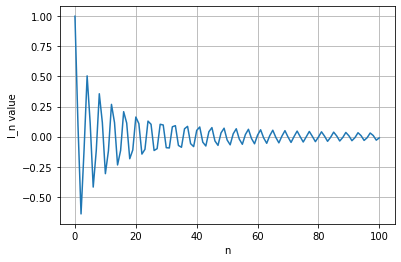

In [11]:
plt.plot(l_n_vec)
plt.xlabel("n")
plt.ylabel("l_n value")
plt.grid()
plt.show()

In [12]:
#just to check if the integrals for x=>150 will be trully computed as 0 anyway (keeping in mind that the higher n the slower it 
#decays)
price_component(150,100)

0.0

In [13]:
%%time
price_vector,iteration_price_change=compute_price (l_n_vec, 0, 150)

for iteration:  0  the error is: 8.88987107565119e-14  and the value is: 0.07965567455405798  the weighted integral has value:  0.07965567455403987
for iteration:  1  the error is: 1.4941259907707096e-14  and the value is: 0.1079655674554058  the weighted integral has value:  0.00989684368340985
for iteration:  2  the error is: 1.031572233735183e-12  and the value is: 0.07140620460252821  the weighted integral has value:  -0.045825737874980586
for iteration:  3  the error is: 5.574489964616891e-12  and the value is: 0.011486382267871154  the weighted integral has value:  -0.0012265507088000975
for iteration:  4  the error is: 1.4689301292399254e-11  and the value is: -0.014894826464586662  the weighted integral has value:  -0.0075188845937682386
for iteration:  5  the error is: 1.8331529213165814e-11  and the value is: -0.003499185095821077  the weighted integral has value:  -0.00039743359570039574
for iteration:  6  the error is: 1.6606340272080217e-11  and the value is: 0.00841319482

for iteration:  56  the error is: 1.7708922756622157e-09  and the value is: -0.000340100801877218  the weighted integral has value:  -5.958378985715386e-06
for iteration:  57  the error is: 1.4389103886274489e-08  and the value is: -0.0003217943140514331  the weighted integral has value:  -1.966076793079889e-05
for iteration:  58  the error is: 8.172215695728181e-09  and the value is: 0.00032125123413485163  the weighted integral has value:  -4.852320061185102e-06
for iteration:  59  the error is: 8.286772498380918e-09  and the value is: 0.0003120784493239018  the weighted integral has value:  -1.847703310728446e-05
for iteration:  60  the error is: 5.031589699989225e-11  and the value is: -0.0003038738109815314  the weighted integral has value:  -3.7761364425901465e-06
for iteration:  61  the error is: 4.243736544126491e-09  and the value is: -0.00030294207440460883  the weighted integral has value:  -1.727664659465062e-05
for iteration:  62  the error is: 7.118480795066528e-11  and t

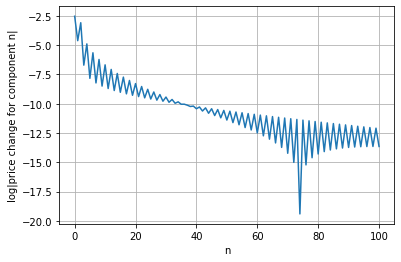

In [14]:
plt.plot(np.log(np.abs(iteration_price_change)))
plt.xlabel("n")
plt.ylabel("log|price change for component n|")
plt.grid()
plt.show()

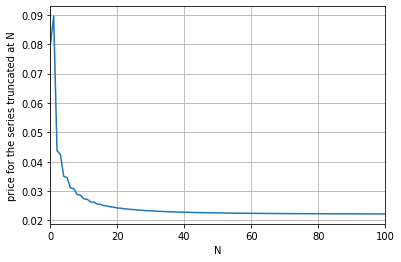

In [15]:
plt.plot(price_vector)
plt.xlabel("N")
plt.ylabel("price for the series truncated at N")
plt.xlim([0,N])
plt.grid()
plt.show()

At the end, for series truncated at 100 the price is:

In [16]:
price_vector[100]

0.02219766139082871

Now we can see what happends if we change the value of those parameters to one:

In [17]:
r=delta=X_0=0.
kappa=0.5
theta=V_0=0.04
v_min=10**(-4)
v_max=0.08
rho=-0.5
sigma=1.
K=1
T=1/12

sigma_w=0.15
mu_w=X_0+(r-delta)*T-sigma_w**2/2

In [18]:
%%time
#the second parameter changes from which iteration stirling approximation is used
N=100
l_n_vec_diff_par=hermite_moments (N, 50, sigma, rho, sigma_w, mu_w, kappa, theta, r, delta,  v_min, v_max, T, V_0, X_0)

Wall time: 1min 24s


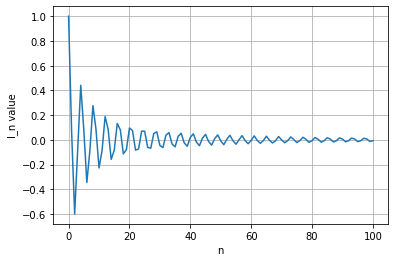

In [19]:
plt.plot(l_n_vec_diff_par)
plt.xlabel("n")
plt.ylabel("l_n value")
plt.grid()
plt.show()

In [20]:
price_component(150,100)

0.0

In [21]:
%%time
price_vector_diff_par,iteration_price_change_diff_par=compute_price (l_n_vec_diff_par, 0, 150)

for iteration:  0  the error is: 2.4344953772020383e-12  and the value is: 0.059785288105789536  the weighted integral has value:  0.05978528810577594
for iteration:  1  the error is: 2.3551944791123935e-11  and the value is: 0.07948389660793422  the weighted integral has value:  0.0050781378388389895
for iteration:  2  the error is: 3.3168486606913704e-11  and the value is: 0.0506259175680472  the weighted integral has value:  -0.03030536824364727
for iteration:  3  the error is: 6.682755449276961e-10  and the value is: 0.006211446500340915  the weighted integral has value:  -0.0004755144884370604
for iteration:  4  the error is: 8.054235056675907e-11  and the value is: -0.011646380958573248  the weighted integral has value:  -0.005139900603433635
for iteration:  5  the error is: 6.96706410532183e-09  and the value is: -0.002004629813273264  the weighted integral has value:  -0.0001660300844722149
for iteration:  6  the error is: 7.695889987779925e-09  and the value is: 0.006473930956

for iteration:  54  the error is: 8.39555447504272e-09  and the value is: 0.00031339870949876795  the weighted integral has value:  -1.8880569197159411e-06
for iteration:  55  the error is: 1.023523561037041e-08  and the value is: 0.00019533822093292677  the weighted integral has value:  -6.845678176400001e-06
for iteration:  56  the error is: 9.914096911975565e-09  and the value is: -0.0002974044334504848  the weighted integral has value:  -2.2896997397501862e-07
for iteration:  57  the error is: 3.106209721326262e-10  and the value is: -0.0001895409907670992  the weighted integral has value:  -6.515194987468862e-06
for iteration:  58  the error is: 9.390125623114391e-09  and the value is: 0.0002826809650136617  the weighted integral has value:  -1.5335795674301855e-06
for iteration:  59  the error is: 4.373833494486702e-09  and the value is: 0.00018410355785428885  the weighted integral has value:  -5.697801267488802e-06
for iteration:  60  the error is: 5.368514535786855e-09  and th

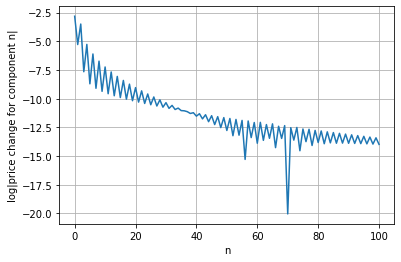

In [22]:
plt.plot(np.log(np.abs(iteration_price_change_diff_par)))
plt.xlabel("n")
plt.ylabel("log|price change for component n|")
plt.grid()
plt.show()

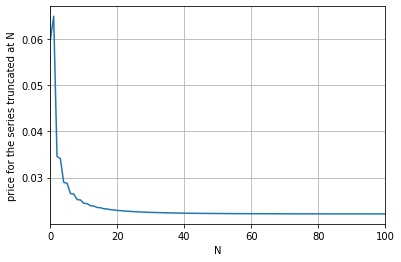

In [23]:
plt.plot(price_vector_diff_par)
plt.xlabel("N")
plt.ylabel("price for the series truncated at N")
plt.xlim([0,N])
plt.grid()
plt.show()

In [24]:
#and we are getting something very similar as before
print(price_vector_diff_par[100])
print(price_vector_diff_par[100]-price_vector[100])

0.02213809713745019
-5.956425337852109e-05


We should note one very interesting thing, let us put here for example sigma_w=1...

In [25]:
r=delta=X_0=0.
kappa=0.5
theta=V_0=0.04
v_min=10**(-4)
v_max=0.08
rho=-0.5
sigma=1.
K=1
T=1/12

sigma_w=1
mu_w=X_0+(r-delta)*T-sigma_w**2/2

In [26]:
%%time
#the second parameter changes from which iteration stirling approximation is used
N=100
l_n_vec_diff_par_2=hermite_moments (N, 50, sigma, rho, sigma_w, mu_w, kappa, theta, r, delta,  v_min, v_max, T, V_0, X_0)

Wall time: 1min 25s


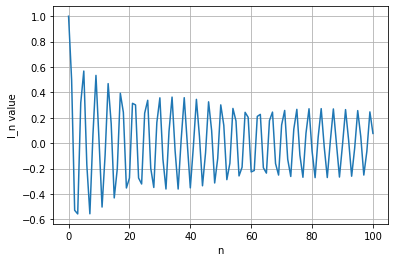

In [27]:
plt.plot(l_n_vec_diff_par_2)
plt.xlabel("n")
plt.ylabel("l_n value")
plt.grid()
plt.show()

In [28]:
price_component(150,100)

0.0

In [29]:
%%time
price_vector_diff_par_2,iteration_price_change_diff_par_2=compute_price (l_n_vec_diff_par_2, 0, 150)

for iteration:  0  the error is: 6.946825146375568e-11  and the value is: 0.3829249225480263  the weighted integral has value:  0.38292492254793925
for iteration:  1  the error is: 4.803447012976386e-09  and the value is: 0.6914624612740131  the weighted integral has value:  0.3445787932014714
for iteration:  2  the error is: 1.5022355172552421e-12  and the value is: 0.737885575278489  the weighted integral has value:  -0.3904377484447849
for iteration:  3  the error is: 5.306177148739238e-13  and the value is: 0.49788346940974093  the weighted integral has value:  -0.2777153694064646
for iteration:  4  the error is: 1.9092292302716814e-11  and the value is: 0.19504295928619805  the weighted integral has value:  0.061963947219912816
for iteration:  5  the error is: 6.984357023839533e-11  and the value is: 0.043034710327945536  the weighted integral has value:  0.024446528410556004
for iteration:  6  the error is: 8.956751871849069e-11  and the value is: 0.038069940754430126  the weight

for iteration:  55  the error is: 9.96831654666234e-09  and the value is: -0.00137393601667826  the weighted integral has value:  -0.00024044660059327244
for iteration:  56  the error is: 1.3914078148356186e-08  and the value is: 0.0017121570646804582  the weighted integral has value:  -0.00044236034521178053
for iteration:  57  the error is: 1.228316681374295e-08  and the value is: 0.0014225579322475843  the weighted integral has value:  -0.0002703245043673047
for iteration:  58  the error is: 6.216252281187782e-09  and the value is: -0.001548057954958567  the weighted integral has value:  -0.00037586126117108586
for iteration:  59  the error is: 1.1330083360628651e-08  and the value is: -0.0014591569272231503  the weighted integral has value:  -0.00029711358541719416
for iteration:  60  the error is: 1.4085384515364756e-08  and the value is: 0.0013924206200739099  the weighted integral has value:  -0.0003158180181938218
for iteration:  61  the error is: 9.812809911699074e-09  and the

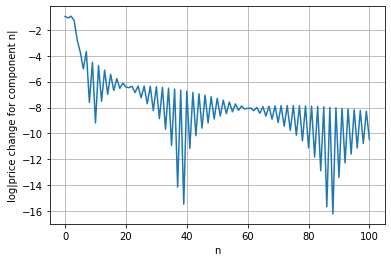

In [30]:
plt.plot(np.log(np.abs(iteration_price_change_diff_par_2)))
plt.xlabel("n")
plt.ylabel("log|price change for component n|")
plt.grid()
plt.show()

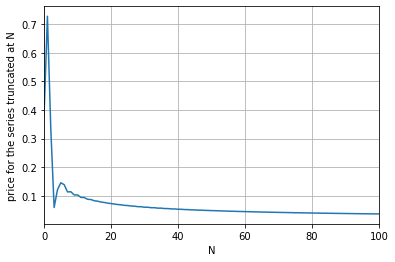

In [31]:
plt.plot(price_vector_diff_par_2)
plt.xlabel("N")
plt.ylabel("price for the series truncated at N")
plt.xlim([0,N])
plt.grid()
plt.show()

And... we are getting something that seems to make no sense, even throuhght the algorithm should work for every sigma_w and mu_w. This issue is caused by the purely numerical reasons, more on that on the report.

In [32]:
print(price_vector_diff_par_2[100])
print(price_vector_diff_par_2[100]-price_vector[100])

0.036888170068343405
0.014690508677514695


In [33]:
print(integrate.quad(stats.norm.pdf,np.NINF,100))
print(integrate.quad(stats.norm.pdf,np.NINF,40))


(0.0, 0.0)
(5.505747798875221e-28, 0.0)


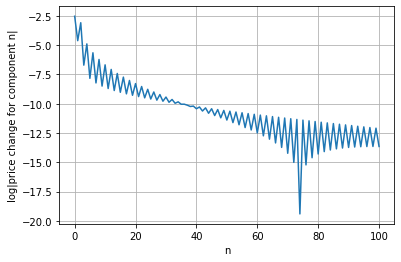

In [34]:
plt.plot(np.log(np.abs(iteration_price_change)))
#plt.plot(np.log(np.abs(iteration_price_change_diff_par)))
plt.xlabel("n")
plt.ylabel("log|price change for component n|")
plt.grid()
plt.show()

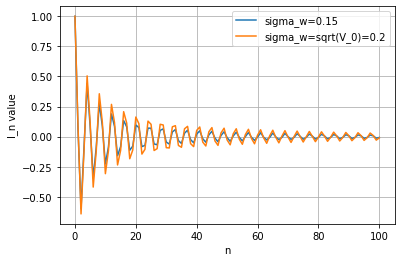

In [35]:
plt.plot(l_n_vec_diff_par,label= "sigma_w=0.15")
plt.plot(l_n_vec, label= "sigma_w=sqrt(V_0)=0.2")
plt.legend(loc="upper right")
plt.xlabel("n")
plt.ylabel("l_n value")
plt.grid()
plt.show()

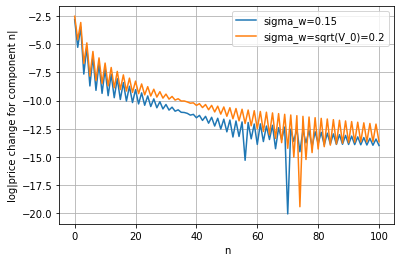

In [36]:
plt.plot(np.log(np.abs(iteration_price_change_diff_par)),label= "sigma_w=0.15")
plt.plot(np.log(np.abs(iteration_price_change)), label= "sigma_w=sqrt(V_0)=0.2")
plt.legend(loc="upper right")
plt.xlabel("n")
plt.ylabel("log|price change for component n|")
plt.grid()
plt.show()

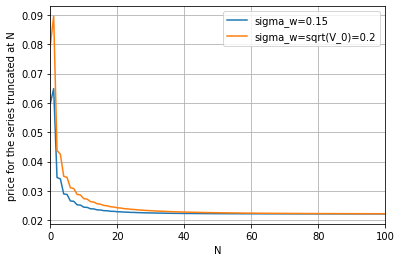

In [37]:
plt.plot(price_vector_diff_par,label= "sigma_w=0.15")
plt.plot(price_vector, label= "sigma_w=sqrt(V_0)=0.2")
plt.legend(loc="upper right")
plt.xlabel("N")
plt.ylabel("price for the series truncated at N")
plt.xlim([0,N])
plt.grid()
plt.show()

In [38]:
r=delta=X_0=0.
kappa=0.5
theta=V_0=0.04
v_min=10**(-4)
v_max=0.08
rho=-0.5
sigma=1.
K=1
T=1/12

sigma_w=0.1
mu_w=X_0+(r-delta)*T-sigma_w**2/2

In [39]:
%%time
#the second parameter changes from which iteration stirling approximation is used
N=100
l_n_vec_diff_par_3=hermite_moments (N, 50, sigma, rho, sigma_w, mu_w, kappa, theta, r, delta,  v_min, v_max, T, V_0, X_0)

Wall time: 1min 30s


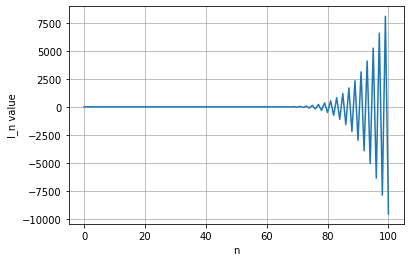

In [40]:
plt.plot(l_n_vec_diff_par_3)
plt.xlabel("n")
plt.ylabel("l_n value")
plt.grid()
plt.show()